In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy

#preprocessing and scoring
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score, precision_score
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline

#models and algos
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

##customer pipeline function
from sklearn.base import BaseEstimator, TransformerMixin

#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Download Sentiment140 dataset
!kaggle datasets download -d "milobele/sentiment140-dataset-1600000-tweets" -p ./datasets

Dataset URL: https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets
License(s): unknown
sentiment140-dataset-1600000-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
import pandas as pd

train_sentiment_data = pd.read_csv("datasets/sentiment-data/training.1600000.processed.noemoticon.csv", names=["polarity","id", "date","query", "user", "tweet"], encoding="ISO-8859-1")
test_sentiment_data  = pd.read_csv("datasets/sentiment-data/testdata.manual.2009.06.14.csv", names=["polarity","id", "date","query", "user", "tweet"], encoding="ISO-8859-1")

In [7]:
train_sentiment_data = train_sentiment_data[["polarity", "tweet"]]
test_sentiment_data = test_sentiment_data[["polarity", "tweet"]]

In [8]:
train_sentiment_data.head()

,polarity,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
test_sentiment_data.columns = ["polarity","tweet"]

In [10]:
train_sentiment_data.shape

(1600000, 2)

In [11]:
train_sentiment_data.head()

,polarity,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
#counting the number of missing values in the dataset
train_sentiment_data.isnull().sum()

polarity    0
tweet       0
dtype: int64

In [13]:
#checking the distribution of the target column
train_sentiment_data['polarity'].value_counts()

polarity
0    800000
4    800000
Name: count, dtype: int64

Convert the target "4" -> "1"               
Convert the target "0" -> "-1"

In [14]:
#Replace values to have -1 negative, 0 neutral, 1 postive
train_sentiment_data["polarity"]  = train_sentiment_data["polarity"].replace(4,1)
train_sentiment_data["polarity"]  = train_sentiment_data["polarity"].replace(0,-1)

test_sentiment_data["polarity"]  = test_sentiment_data["polarity"].replace(4,1)
test_sentiment_data["polarity"]  = test_sentiment_data["polarity"].replace(0,-1)
test_sentiment_data["polarity"]  = test_sentiment_data["polarity"].replace(2,0)

-1 --> Negative          
1 --> Positive

In [15]:
train_sentiment_data['polarity'].value_counts()

polarity
-1    800000
 1    800000
Name: count, dtype: int64

In [16]:
print("Sentiment_train_data_len: ", len(train_sentiment_data))
print("Sentiment_test_data_len: ", len(test_sentiment_data))

Sentiment_train_data_len:  1600000
Sentiment_test_data_len:  498


In [17]:
tweets_df = pd.concat([train_sentiment_data,test_sentiment_data],axis=0)

In [18]:
tweets_df.head()

,polarity,tweet
0,-1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,-1,is upset that he can't update his Facebook by ...
2,-1,@Kenichan I dived many times for the ball. Man...
3,-1,my whole body feels itchy and like its on fire
4,-1,"@nationwideclass no, it's not behaving at all...."


<Axes: xlabel='polarity', ylabel='count'>

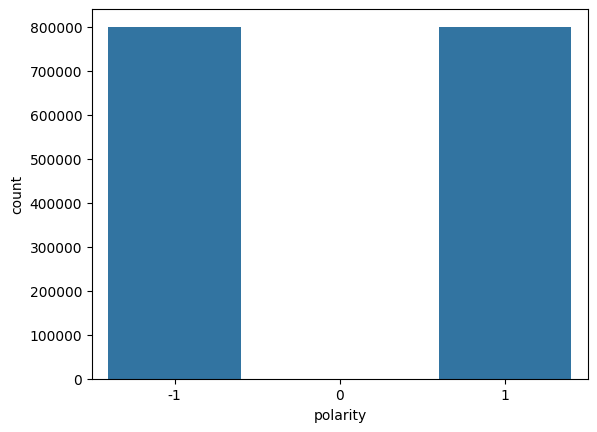

In [19]:
sns.countplot(data = tweets_df , x = "polarity")

In [20]:
tweets_df["tweet"] = tweets_df["tweet"].astype(str)
tweets_df.reset_index(drop = True,inplace=True)

In [21]:
# Length
tweets_df["length"] = tweets_df["tweet"].apply(len)

In [22]:
tweets_df.groupby("polarity")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
polarity,,,,,,,,
-1,800177.0,74.304081,36.743642,6.0,44.0,70.0,104.0,359.0
0,139.0,72.517986,32.992391,11.0,48.0,69.0,95.0,144.0
1,800182.0,73.880350,36.135391,6.0,44.0,69.0,103.0,374.0


<Figure size 1500x500 with 0 Axes>

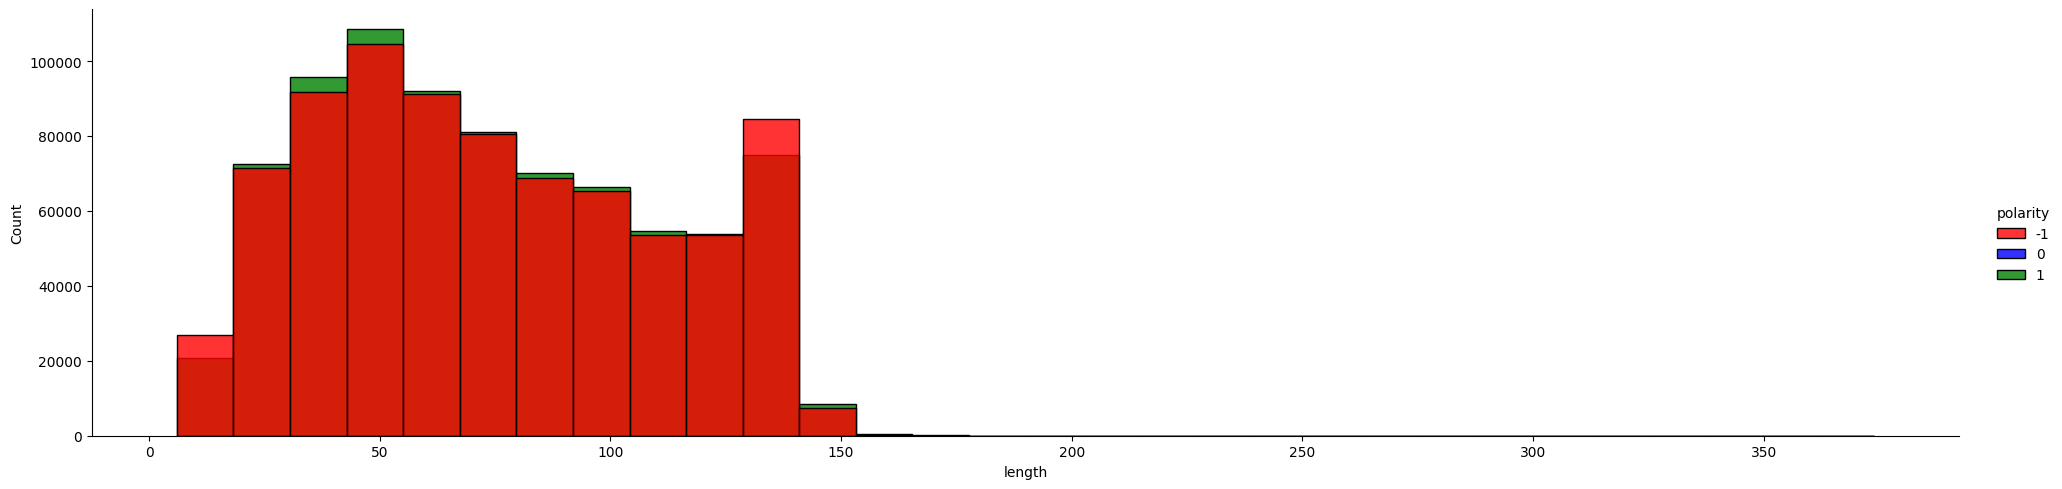

In [23]:
plt.figure(figsize=(15,5))

sns.displot(data = tweets_df, x= "length", hue= "polarity" ,palette={-1:"r", 0:"b",1:"g"}, bins = 30,aspect= 4, alpha = 0.8)

**Data Cleaning**

In [24]:
def clean_text(text):
    pat1 = r'@[^ ]+'                   #param
    pat2 = r'https?://[A-Za-z0-9./]+'  #links
    pat3 = r'\'s'                      #floating s's
    pat4 = r'\#\w+'                     # hashtags and value
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'         #remove non-alphabet
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5, pat6))
    text = re.sub(combined_pat,"",text).lower()
    return text.strip()

In [25]:
#cleaned dataframe
tweets_df["cleaned_tweet"] = tweets_df["tweet"].apply(clean_text)

In [26]:
tweets_df.head()

,polarity,tweet,length,cleaned_tweet
0,-1,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww that a bummer you shoulda got david carr...
1,-1,is upset that he can't update his Facebook by ...,111,is upset that he cant update his facebook by t...
2,-1,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball managed to sav...
3,-1,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
4,-1,"@nationwideclass no, it's not behaving at all....",111,no it not behaving at all im mad why am i here...


In [27]:
#drop empty column
tweets_df = tweets_df [ ~(tweets_df["cleaned_tweet"] =="")]

**Lemmetization**

In [28]:
word_lem = WordNetLemmatizer()

def tokenize_lem(sentence):
    outlist= []
    tokens = sentence.split()
    for token in tokens:
        outlist.append(word_lem.lemmatize(token))
    return " ".join(outlist)

In [29]:
tweets_df["cleaned_tweet"] = tweets_df["cleaned_tweet"].apply(tokenize_lem)

In [30]:
tweets_df.head()

,polarity,tweet,length,cleaned_tweet
0,-1,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww that a bummer you shoulda got david carr ...
1,-1,is upset that he can't update his Facebook by ...,111,is upset that he cant update his facebook by t...
2,-1,@Kenichan I dived many times for the ball. Man...,89,i dived many time for the ball managed to save...
3,-1,my whole body feels itchy and like its on fire,47,my whole body feel itchy and like it on fire
4,-1,"@nationwideclass no, it's not behaving at all....",111,no it not behaving at all im mad why am i here...


In [89]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596552 entries, 0 to 1600497
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   polarity       1596552 non-null  int64 
 1   tweet          1596552 non-null  object
 2   length         1596552 non-null  int64 
 3   cleaned_tweet  1596552 non-null  object
dtypes: int64(2), object(2)
memory usage: 60.9+ MB


In [90]:
tweets_df.shape

(1596552, 4)

Splitting the data into training and test data

In [110]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df[["cleaned_tweet", "length"]], tweets_df['polarity'], test_size=0.1, random_state=42)

**TF-IDF** -> Vectorize the tweets

In [111]:
tf_idf = TfidfVectorizer()
tf_idf.fit(X_train["cleaned_tweet"])

X_train_v = tf_idf.transform(X_train["cleaned_tweet"])
X_test_v = tf_idf.transform(X_test["cleaned_tweet"])

In [112]:
print("X_train_v_shape: ", X_train_v.shape)
print("X_test_v_shape: ", X_test_v.shape)

X_train_v_shape:  (1436896, 374093)
X_test_v_shape:  (159656, 374093)


Add TFIDF to tweets vector and Scaling

In [113]:
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

In [114]:
scaler.fit([X_train['length']])
scaler2.fit([X_test['length']])

MinMaxScaler()

In [115]:
X_train_len = scaler.transform([X_train["length"]])
X_train_len = X_train_len.reshape( X_train_v.shape[0], 1)

X_train = scipy.sparse.hstack([X_train_v,X_train_len], format = "csr")

**Algorithms used:**
Random Forest
LinearSVC
Naive Bayes (Bernoulini and Multinomial)
XGBoost
Logistic Regression
Ridge

Out-the-box models for comparison:
Textblob
Vader**

GridSearchCV

Due to the time some of these models took to run, the tuning for the below models were was done outside Kaggle and as a result some parameter iterations were reduced:

In [116]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [117]:
model_score = pd.DataFrame(columns=["model_f1_train","params_used", "f1","precision","recall"])

def model_prediction(model, params):

    model = GridSearchCV(model, param_grid= params, cv= kfold)

    model.fit(X_train_v, y_train)
    y_pred = model.predict(X_test_v)

    print ("Model and params: ", model.best_estimator_, model.best_params_)
    print("\n")
    print("Train score: ", model.best_score_)
    print("test score: ",accuracy_score(y_test,y_pred))
    print("\n")
    print("Test Report:")
    print(classification_report(y_test,y_pred))
    return y_pred, model


In [118]:
def model_scoring(y_pred, model):
    global y_test
    global model_score

    # Create a DataFrame for the new data
    df = pd.DataFrame(
        data=[[model.best_score_,
               model.best_params_,
               f1_score(y_test, y_pred, average="macro"),
               precision_score(y_test, y_pred, average="macro"),
               recall_score(y_test, y_pred, average="macro")]],
        columns=model_score.columns,
        index=[str(model.best_estimator_)]
    )

    # Use pd.concat instead of append
    model_score = pd.concat([model_score, df])

In [119]:
#Set Parameters
gen_params = {"alpha":[1,3]}
xgb_params = {
        'n_estimators': [200],
        'max_depth': [9],
        'eta': [0.5],
}
lnSVC_params = {
    "C": [1]
}
logr_params = {
    "penalty": ["l2"],
    'C': [0.01, 0.1, 1, 10],
    "max_iter": [10000],
    'solver': ['liblinear', 'lbfgs']
}
forest_params = {
    "n_estimators": [100],
    "max_depth" : [8]
}

In [120]:
#Instantiate
vader = SentimentIntensityAnalyzer()
#textblob does not required instantiation

logr_i = LogisticRegression(solver="sag")
ridge_i = RidgeClassifier()                 # L2 regularization
lnSVC_i = LinearSVC()
naivemulti_i = MultinomialNB()
naivebern_i = BernoulliNB()
xgb_i = XGBClassifier(#tree_method='gpu_hist'
                     )
rf_i = RandomForestClassifier()

**Due to the time take to run the below models (+9hrs) I have excluded all except random forest

Note thet XGBoost has the highest accruacy and f1 score of all the models used**

Logistic Regression

In [121]:
log_pred , logr_m = model_prediction(logr_i, logr_params)

Model and params:  LogisticRegression(C=1, max_iter=10000, solver='liblinear') {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}


Train score:  0.797687514844456
test score:  0.7960677957608859


Test Report:
              precision    recall  f1-score   support

          -1       0.80      0.79      0.79     79416
           0       0.00      0.00      0.00        14
           1       0.79      0.80      0.80     80226

    accuracy                           0.80    159656
   macro avg       0.53      0.53      0.53    159656
weighted avg       0.80      0.80      0.80    159656



c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [122]:
ridge_pred, ridge_m = model_prediction(ridge_i,{"alpha":[3]})

Model and params:  RidgeClassifier(alpha=3) {'alpha': 3}


Train score:  0.7942592920420711
test score:  0.7930488049306008


Test Report:
              precision    recall  f1-score   support

          -1       0.80      0.78      0.79     79416
           0       0.00      0.00      0.00        14
           1       0.79      0.80      0.80     80226

    accuracy                           0.79    159656
   macro avg       0.53      0.53      0.53    159656
weighted avg       0.79      0.79      0.79    159656



c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [123]:
linSVC_pred, lnSVC_m = model_prediction(lnSVC_i, lnSVC_params)

Model and params:  LinearSVC(C=1) {'C': 1}


Train score:  0.7916237500177241
test score:  0.790612316480433


Test Report:
              precision    recall  f1-score   support

          -1       0.79      0.78      0.79     79416
           0       0.00      0.00      0.00        14
           1       0.79      0.80      0.79     80226

    accuracy                           0.79    159656
   macro avg       0.53      0.53      0.53    159656
weighted avg       0.79      0.79      0.79    159656



In [124]:
model_scoring(log_pred, logr_m)
model_scoring(ridge_pred, ridge_m)
model_scoring(linSVC_pred, lnSVC_m)

c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Anshu\AppData\Local\Temp\ipykernel_19416\661214351.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_score = pd.concat([model_score, df])
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [125]:
model_score

,model_f1_train,params_used,f1,precision,recall
"LogisticRegression(C=1, max_iter=10000, solver='liblinear')",0.797688,"{'C': 1, 'max_iter': 10000, 'penalty': 'l2', '...",0.530714,0.530758,0.530730
RidgeClassifier(alpha=3),0.794259,{'alpha': 3},0.528688,0.528795,0.528705
LinearSVC(C=1),0.791624,{'C': 1},0.527081,0.527112,0.527095


Out-the box models

Textblob, Vader

In [126]:
def out_box_textblob(x):
    x = TextBlob(x).sentiment[0]
    if x >0:
        x = 1
    elif x<0:
        x = -1
    else:
        x= 0
    return x

In [127]:
def out_box_vader(x):
    x = vader.polarity_scores(x)["compound"]
    if x >0:
        x = 1
    elif x<0:
        x = -1
    else:
        x= 0
    return x

In [128]:
def out_box_score(y_true, prediction, name):
    global model_score

    # Create a DataFrame for the new data
    df = pd.DataFrame(
        data=[[0,
               0,
               f1_score(y_true, prediction, average="macro"),
               precision_score(y_true, prediction, average="macro"),
               recall_score(y_true, prediction, average="macro")]],
        columns=model_score.columns,
        index=[name]
    )

    model_score = pd.concat([model_score, df])

In [129]:
textblob_pred = tweets_df["cleaned_tweet"].apply(out_box_textblob)
vader_pred = tweets_df["cleaned_tweet"].apply(out_box_vader)

out_box_score(tweets_df["polarity"],vader_pred, "Vader")
out_box_score(tweets_df["polarity"],textblob_pred,"Textblob")

In [130]:
model_score

,model_f1_train,params_used,f1,precision,recall
"LogisticRegression(C=1, max_iter=10000, solver='liblinear')",0.797688,"{'C': 1, 'max_iter': 10000, 'penalty': 'l2', '...",0.530714,0.530758,0.530730
RidgeClassifier(alpha=3),0.794259,{'alpha': 3},0.528688,0.528795,0.528705
LinearSVC(C=1),0.791624,{'C': 1},0.527081,0.527112,0.527095
Vader,0.000000,0,0.400271,0.483946,0.576141
Textblob,0.000000,0,0.347196,0.462514,0.514029


**Save the model & vocab**

In [132]:
model_dict = {
    logr_m : "logr_m",
    ridge_m:"ridge_m",lnSVC_m:"lnSVC_m"
             }
for m in model_dict.items():
    file = open(f'{m[1]}.pickle','wb')
    pickle.dump(m[0], file)
    file.close()

In [133]:
## save vocabulary
with open("vocabulary","wb") as f:
    pickle.dump(tf_idf.vocabulary_,f)
    f.close()

**Pipeline**

In [134]:
# Assuming tweets_df is already defined and contains 'cleaned_tweet' and 'polarity'
X = tweets_df["cleaned_tweet"]
y = tweets_df["polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [135]:
# Define the pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('classifier', MultinomialNB())  # Use Naive Bayes as the classifier
])

In [136]:
# Fit the model
pipe.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [137]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.80      0.83      0.81    238858
           0       0.00      0.00      0.00        45
           1       0.82      0.79      0.81    240063

    accuracy                           0.81    478966
   macro avg       0.54      0.54      0.54    478966
weighted avg       0.81      0.81      0.81    478966



c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anshu\Desktop\ml_lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
